In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


/Users/user/Desktop/ongoing/Credit_Fraud


In [11]:
LABELS = ["NO FRAUD", "FRAUD"]

df = pd.read_csv("dataset/creditcard.csv")

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [12]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [14]:
# split  data to train and test
X_train, X_test = train_test_split(data, test_size=0.2, random_state= 42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

In [15]:
#build model
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 88
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,
                    validation_data=(X_test, X_test),verbose=1,callbacks=[checkpointer, tensorboard]).history


autoencoder = load_model('model.h5')

Epoch 1/88
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpcrfpxax5.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpcrfpxax5.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7108/7108 [==============================] - 38s 2ms/step - loss: 0.8838 - accuracy: 0.4417 - val_loss: 0.7776 - val_accuracy: 0.6475
Epoch 2/88
7108/7108 [==============================] - 15s 2ms/step - loss: 0.7326 - accuracy: 0.6471 - val_loss: 0.7574 - val_accuracy: 0.6557
Epoch 3/88
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7174 - accuracy: 0.6587 - v

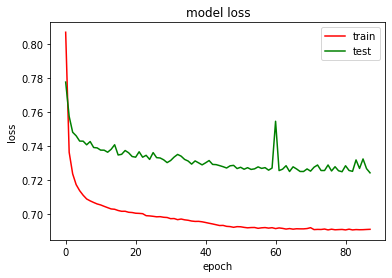

In [16]:
#plot epoch vs error/loss
plt.plot(history['loss'], color = "red")
plt.plot(history['val_loss'], color = "green")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()


In [17]:
#predict error
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print(error_df.describe())

       reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.723346      0.001720
std                3.342390      0.041443
min                0.048027      0.000000
25%                0.236376      0.000000
50%                0.384202      0.000000
75%                0.619251      0.000000
max              257.939591      1.000000


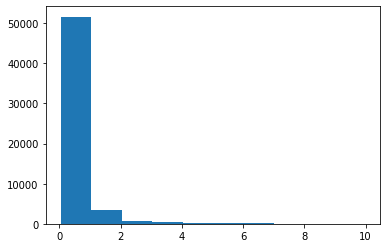

In [18]:
#no fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.show()

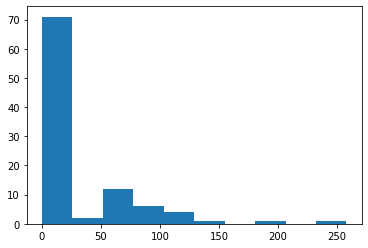

In [19]:
#fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.show()

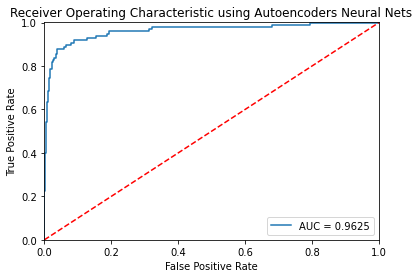

In [24]:
#auc roc curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic using Autoencoders Neural Nets')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

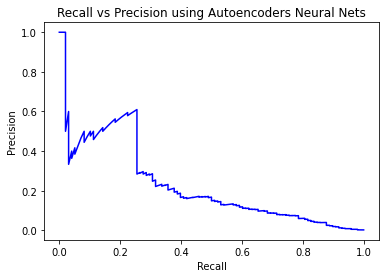

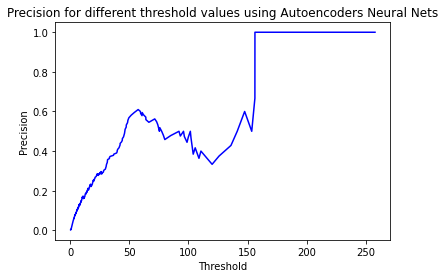

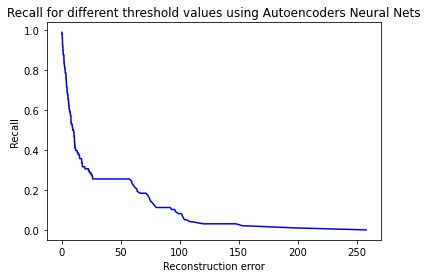

In [25]:
#percision recall curves
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision using Autoencoders Neural Nets')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values using Autoencoders Neural Nets')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values using Autoencoders Neural Nets')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

threshold = 3.5

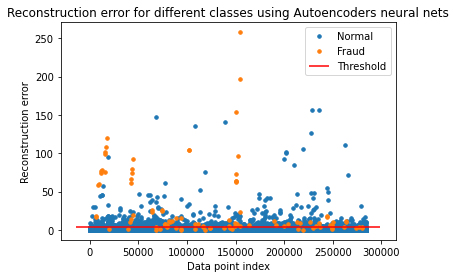

In [26]:
#predictions
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes using Autoencoders neural nets")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


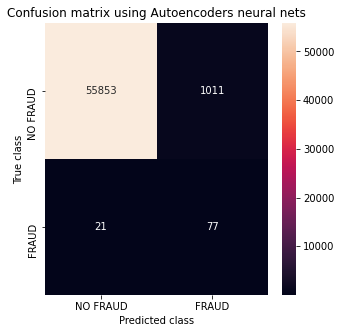

In [27]:
#confusion matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix using Autoencoders neural nets")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()